# 1. Configuración del ambiente

## 1.1 Definición de variables

En el proyecto se usan 5 variables que serán manipuladas dentro de varias funciones, estas variables son conocidas como variables globales, se definen de la siguiente forma:

In [1]:
global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision

## 1.2 Instalar librerías

In [2]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import yfinance as yf

import requests
from bs4 import BeautifulSoup

from IPython.display import clear_output
import time

## 1.3 Comprobar librerías y versiones

In [3]:
!python -V
print('------')
!pip show Pandas | grep 'Name\|Version'
print('------')
!pip show Numpy | grep 'Name\|Version'
print('------')
!pip show Matplotlib | grep 'Name\|Version'

Python 3.10.11
------
Name: pandas
Version: 1.5.3
------
Name: numpy
Version: 1.22.4
------
Name: matplotlib
Version: 3.7.1


# 2. Obtención de datos

Se utiliza la biblioteca [yfinance](https://pypi.org/project/yfinance/) de Python para extraer el histórico de precios del Bitcoin en dólares BTC-USD, se debe extraer el histórico de los últimos 7 días en intervalos de 5 minutos, este histórico se guarda en el dataframe `df_bitcoin`.

##2.1 Importar la base bitcoin histórico

In [4]:
# Crear la función importar_base_bitcoin()

def importar_base_bitcoin():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision
  btcn = yf.Ticker("BTC-USD")
  df_bitcoin = btcn.history(period="7d", interval = "5m")

importar_base_bitcoin()
df_bitcoin

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-05-26 00:00:00+00:00,26486.089844,26486.089844,26480.951172,26481.548828,0,0.0,0.0
2023-05-26 00:05:00+00:00,26481.531250,26481.531250,26460.160156,26460.160156,0,0.0,0.0
2023-05-26 00:10:00+00:00,26450.755859,26457.359375,26444.072266,26457.144531,0,0.0,0.0
2023-05-26 00:15:00+00:00,26455.166016,26466.228516,26455.166016,26466.228516,4686848,0.0,0.0
2023-05-26 00:20:00+00:00,26464.923828,26498.097656,26464.923828,26498.097656,0,0.0,0.0
...,...,...,...,...,...,...,...
2023-06-01 02:45:00+00:00,27048.791016,27048.791016,27029.955078,27029.955078,18784256,0.0,0.0
2023-06-01 02:50:00+00:00,26785.921875,26785.921875,26742.402344,26752.451172,308943872,0.0,0.0
2023-06-01 02:55:00+00:00,26718.642578,26740.226562,26690.888672,26721.234375,203149312,0.0,0.0


##2.2 Webscraping

Utilizando la biblioteca BeautifulSoup se realiza el [Web Scraping](https://www.youtube.com/watch?v=IKlwNKG2dus&t=972s) de la página https://coinmarketcap.com/ para extraer el precio actual del Bitcoin BTC en dólares USD y la variación de su precio en la última hora 1h % .
El precio debe convertirse a `float` y guardarse en la variable llamada `precio_actual`.
La variable `tendencia` guarda el valor de `'baja'`, si la variación del precio es negativa, sino, guarda el valor de `'alta'`.

In [5]:
def limpiar_precio(raw):
  return float(raw.replace("$", "").replace(",",""))

#limpiar_precio("$27,071.70")

In [6]:
def extraer_tendencias():
 global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision
 headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36'}
 url = 'https://coinmarketcap.com'
 response = requests.get(url, headers=headers)
 response.raise_for_status() #se detiene en caso de error
 soup = BeautifulSoup(response.content, 'lxml')
 parrafo_btc = soup.find("p", string="Bitcoin")
 celda_btc = parrafo_btc.find_parent("td")
 celda_precio = celda_btc.find_next_sibling()
 precio_actual = limpiar_precio(celda_precio.text)

 #Calculando la tendencia exclusivamente del Bitcoin
 lista = []
 etiqueta = soup.find_all('span', {'class':['sc-97d6d2ca-0 cYiHal','sc-97d6d2ca-0 bQjSqS']})
 for item in etiqueta[::3]:
   lista.append(item)
 tendencia = ''
 indice=0
 if lista[indice].find('span')['class'][0] == 'icon-Caret-down':
   tendencia = 'baja'
 else:
   tendencia = 'alta'

 #print(precio_actual, tendencia)

In [7]:
extraer_tendencias()

# 3. Limpieza de datos

Se crea una copia de la base `df_bitcoin` para realizar la limpieza en esta nueva base `(df_bitcoin_limpio)`, sin modificar la base original, además es importante entender su contenido:

*   Datetime: Es el índice del dataframe, y contiene la fecha y hora del intervalo seleccionado, no puede estar duplicado.
*   Open: Contiene el precio del Bitcoin al inicio del intervalo.
*   High: Contiene el precio más alto del Bitcoin durante el intervalo.
*   Low: Contiene el precio más bajo del Bitcoin durante el intervalo.
*   Close: Contiene el precio del Bitcoin al final del intervalo.
*   Volume: Contiene el total de transacciones hechas durante el intervalo.

Se analiza la base `df_bitcoin_limpio`, se identifican duplicados en el índice y se tratan para quedarse sólo con índices únicos.

Se buscan valores nulos en la columna `Close` y se tratan.

Se verifica que todos los registros de la base tengan un `Volume` de transacción mayor a 0, caso contrario, se eliminan.

Se identifican y eliminan los outliers en el precio del Bitcoin, columna `Close`, utilizando un gráfico de boxplot para identificarlos.

Se seleccionan únicamente los registros cuyo `precio(Close)` se encuentren entre el 1er cuartil `(Q1)` y el 3er cuartil `(Q3)` del boxplot.

Finalmente, se calcula el precio `promedio(Close)` de la selección y se guarda en la variable `media_bitcoin`.

##3.1 Limpieza de datos y Boxplot

In [8]:
#Se crea la funcion limpieza de datos()
def limpieza_datos():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision
  
  #Se crea una copia de la base df_bitcoin para realizar la limpieza en esta nueva base (df_bitcoin_limpio)
  df_bitcoin_limpio = df_bitcoin.copy()

  #Se analiza la base df_bitcoin_limpio, se identifican duplicados en el índice y se tratan para quedarse sólo con índices únicos.
  #Duplicated identifica los valores del index duplicados y les asigna True, al negarlo devuelve solo los valores no duplicados
  #https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.duplicated.html
  df_bitcoin_limpio = df_bitcoin_limpio[~df_bitcoin_limpio.index.duplicated()]

  #Se buscan valores nulos en la columna Close y se tratan.
  #Interpolate rellena los nulos utilizando un método de interpolación para una serie
  #https://pandas.pydata.org/docs/reference/api/pandas.Series.interpolate.html
  df_bitcoin_limpio.Close.interpolate(inplace = True)

  #Se verifica que todos los registros de la base tengan un Volume de transacción mayor a 0, caso contrario, se eliminan.
  seleccion = df_bitcoin_limpio['Volume'] > 0
  df_bitcoin_limpio = df_bitcoin_limpio[seleccion]

  #Se identifican y eliminan los outliers en el precio del Bitcoin, columna Close, utilizando un gráfico de boxplot para identificarlos.
  df_bitcoin_limpio.boxplot(['Close'])
  valor = df_bitcoin_limpio['Close']

  #Se seleccionan únicamente los registros cuyo precio(Close) se encuentren entre el 1er cuartil (Q1) y el 3er cuartil (Q3) del boxplot.
  Q1 = valor.quantile(.25)
  Q3 = valor.quantile(.75)
  IIQ = Q3 - Q1
  limite_inferior = Q1 - 1.5 * IIQ
  limite_superior = Q3 + 1.5 * IIQ
  seleccion = ((valor >= limite_inferior) & (valor <= limite_superior))
  df_bitcoin_limpio = df_bitcoin_limpio[seleccion]

  #Finalmente, se calcula el precio promedio(Close) de la selección y se guarda en la variable media_bitcoin.
  media_bitcoin = df_bitcoin_limpio.Close.mean().round(2)
  media_bitcoin 

27332.08

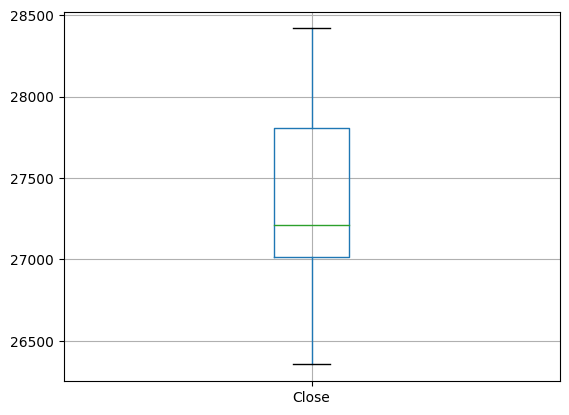

In [9]:
limpieza_datos()
media_bitcoin

# 4. Tomar decisiones

La variable algoritmo_decision toma el valor, de acuerdo al siguiente criterio de decisión:

*   Si el precio actual es mayor/igual que el precio promedio y la tendencia es de baja, entonces guarda el valor ‘Vender’.
*  Si el precio actual es menor que el precio promedio y la tendencia es de alta, entonces guarda el valor ‘Comprar’.
*   Si ninguna de las 2 condiciones anteriores se cumple, entonces guarda el valor ''.

In [10]:
#Crear funcion tomar_decisiones()
def tomar_decisiones():
  global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision

  #Si el precio actual es mayor/igual que el precio promedio y la tendencia es de baja, entonces guarda el valor ‘Vender’.
  if ((precio_actual >= media_bitcoin) and (tendencia == 'baja')):
     algoritmo_decision = 'Vender'

  #Si el precio actual es menor que el precio promedio y la tendencia es de alta, entonces guarda el valor ‘Comprar’.
  elif ((precio_actual < media_bitcoin) and (tendencia == 'alta')):
    algoritmo_decision = 'Comprar'

  #Si ninguna de las 2 condiciones anteriores se cumple, entonces guarda el valor ''.
  else:
    algoritmo_decision = 'No comprar o vender'
  
  #print(algoritmo_decision)

In [11]:
tomar_decisiones()

# 5. Visualización

Se adiciona una nueva columna `(Promedio)` al dataframe original `df_bitcoin ` para almacenar el valor de la variable `media_bitcoin`.

Se configura el tamaño del gráfico en una proporción de 16x5.

Se coloca un título al gráfico.

Usando el método `plot()`, se dibuja una línea en el gráfico, con los datos del índice y la columna `Close` de la base `df_bitcoin.`

Usando el método `plot()`, se dibuja una línea en el gráfico, con los datos del índice y la columna `Promedio` de la base `df_bitcoin`.

Usando el método `annotate()`, se muestra un mensaje dentro del gráfico con la decisión calculada del algoritmo.

Finalmente, usando el método `show()`, se muestra en pantalla el gráfico que se acaba de configurar.

In [12]:
#Crear funcion visualizacion()

def visualizacion():
  #Se adiciona una nueva columna (Promedio) al dataframe original df_bitcoin para almacenar el valor de la variable media_bitcoin.
  df_bitcoin['Promedio'] = media_bitcoin

  #Se configura el tamaño del gráfico en una proporción de 16x5.
  plt.figure(figsize=((16,5)))

  #Se coloca un título al gráfico.
  plt.title('Robot Trading Bitcoin', loc='left', fontsize=24)

  #Usando el método plot(), se dibuja una línea en el gráfico, con los datos del índice y la columna Close de la base df_bitcoin.
  plt.plot(df_bitcoin.index, df_bitcoin['Close'], color='green')

  #Usando el método plot(), se dibuja una línea en el gráfico, con los datos del índice y la columna Promedio de la base df_bitcoin.
  plt.plot(df_bitcoin.index, df_bitcoin['Promedio'], color='purple')

  #Usando el método annotate(), se muestra un mensaje dentro del gráfico con la decisión calculada del algoritmo.
  plt.annotate(algoritmo_decision, xy=(0.8, 0.8), xycoords='axes fraction', fontsize=16, color='red')

  #Finalmente, usando el método show(), se muestra en pantalla el gráfico que se acaba de configurar.
  plt.show()

  #Imprimimos tendencia
  print('Tendencia:', tendencia)

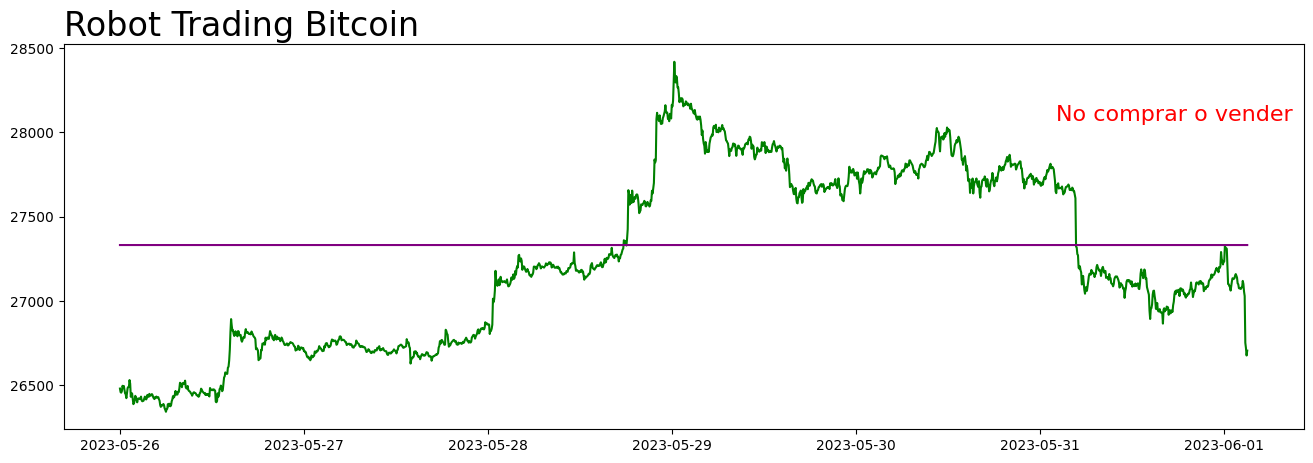

Tendencia: baja


In [13]:
visualizacion()

# 6. Automatización

Se importa el método `'clear_output()'`, este método permite borrar los resultados de la pantalla antes de imprimir un nuevo gráfico, y así evitar tener más de un gráfico en la pantalla, se importa de la siguiente forma: `from IPython.display import clear_output`.

 También se importa la biblioteca `‘time’` de la siguiente forma: `import time`, se utiliza el método `time.sleep(300)` para interrumpir la ejecución del código cada 300 segundos o 5 minutos.

Finalmente se construye un loop infinito para ejecutar permanentemente y en intervalos de 5 minutos, las funciones que se construyeron en los pasos 2 al 5 del proyecto, de la siguiente forma:


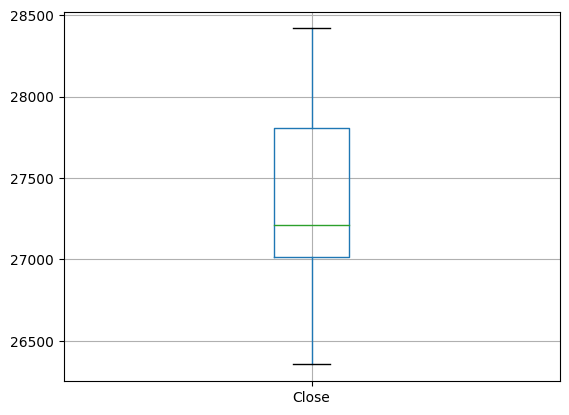

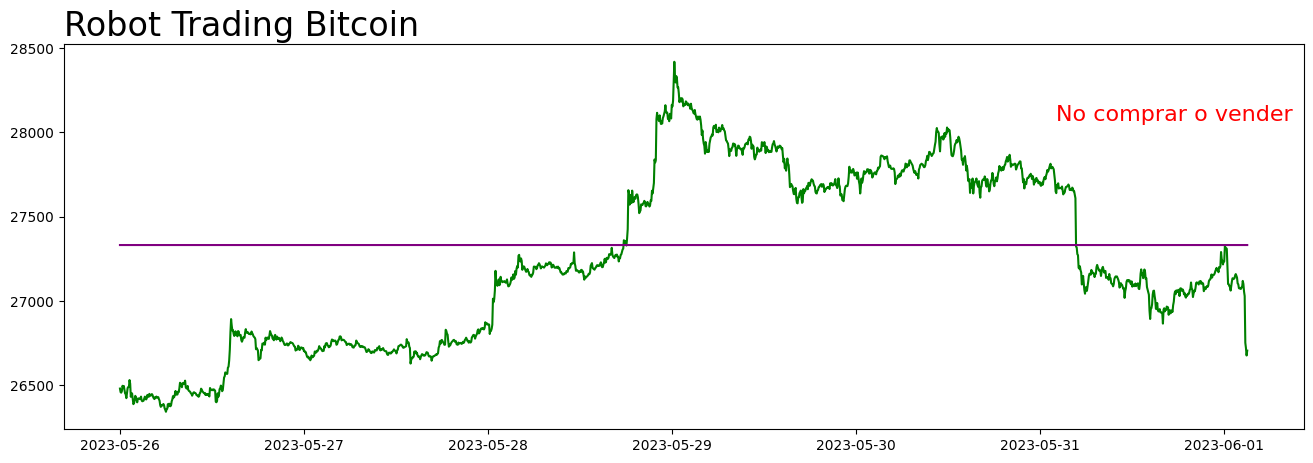

Tendencia: baja


KeyboardInterrupt: ignored

In [14]:
while(True):
  clear_output()
  importar_base_bitcoin()
  extraer_tendencias()
  limpieza_datos()
  tomar_decisiones()
  visualizacion()
  time.sleep(300)

El resultado es el gráfico anterior, el cual muestra el histórico de precios del Bitcoin y la decisión del algoritmo en tiempo real, basado en datos normalizados y limpios, que se actualizan cada 5 minutos.